## **Aplicação de Regressão Linear Simples e Múltipla**
Neste notebook são aplicados os modelos de regressão linear simples e múltipla, bem como a construção de features para captura de sazonalidade e outras características das séries temporais.
Para avaliação do desempenho do modelo, serão utilizadas as métricas **MAE**, **MSE**, **RMSE** e **R²**, comparados aos modelos benchmark **SARIMA** e **ETS**. 

In [1]:
# confirgurando diretório
import os
os.chdir("..")

# importando bibliotecas
import warnings
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from statsforecast import StatsForecast 
from statsforecast.models import AutoARIMA, AutoETS
from main.features import add_features
from main.evaluation import Evaluation
from main.plots import plot_metrics
from main.plots import plot_time_series

# configurando notebook
tqdm.pandas()

warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '%.2f' % x)

%load_ext autoreload
%autoreload 2

EVAL_PATH = 'notebooks/data/evaluation.csv'

## **Leitura dos Dados**
Leitura dos dados de treino e teste exportados no notebook *analise_exploratoria.ipynb*. Para cada série, foram separados os 70% primeiros pontos de dados para treino e o restante, ou seja, os dados mais recentes, para teste.

In [2]:
# leitura dos dados
train_df = pd.read_csv("notebooks/data/train_df.csv", parse_dates=['ds'])
test_df = pd.read_csv("notebooks/data/test_df.csv", parse_dates=['ds'])

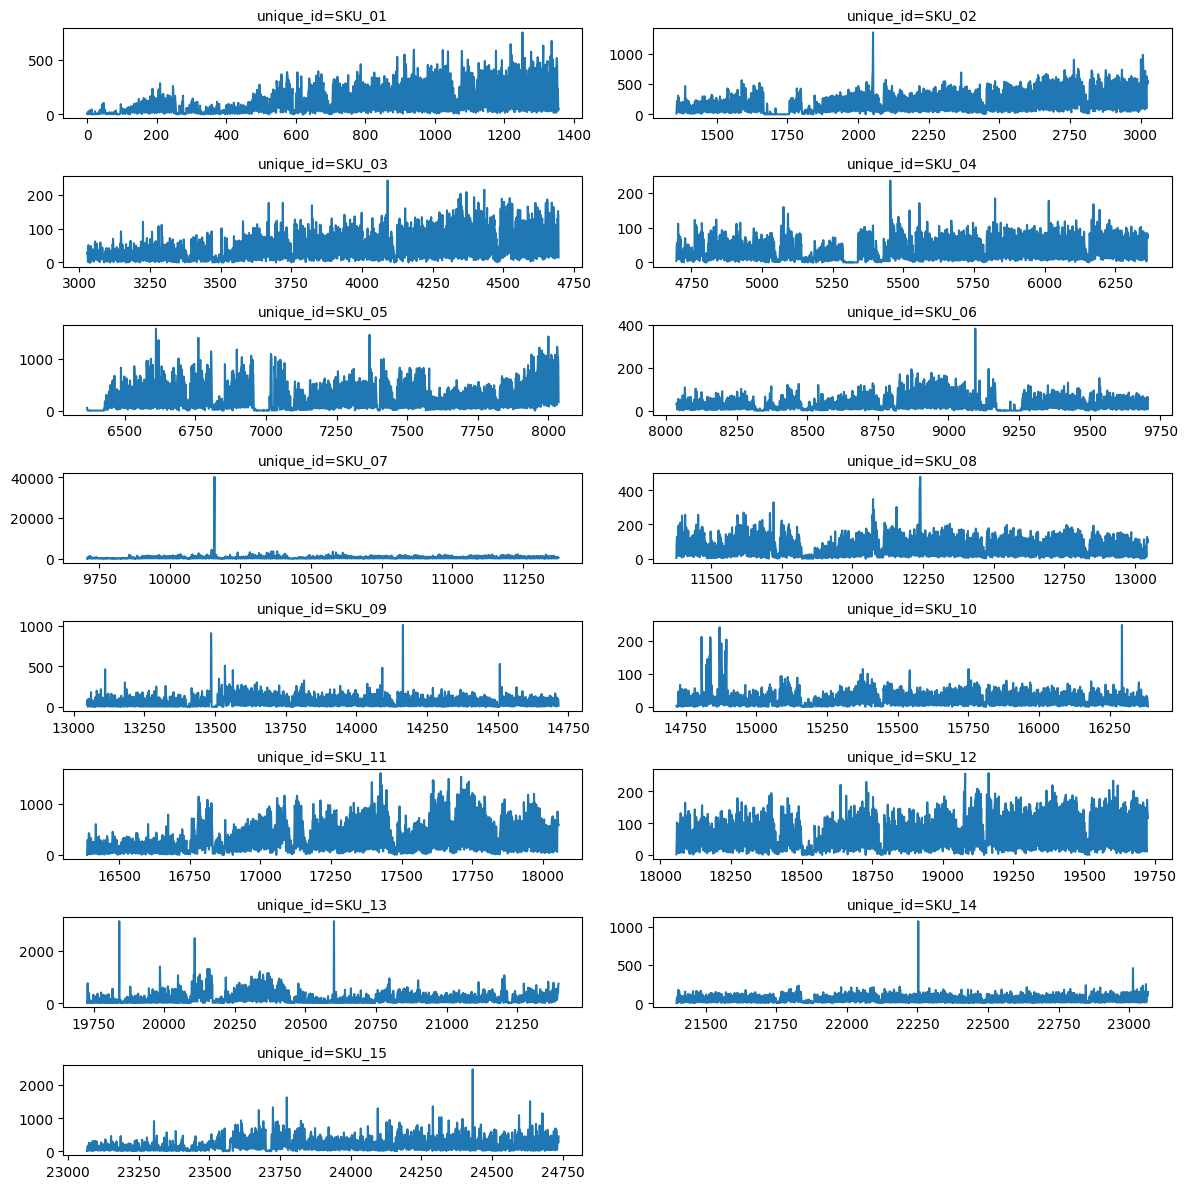

In [3]:
# visualizando dados de treino
plot_time_series(df=train_df, data_cols=['y'], figsize=(12,12))

## **Regressão Linear Simples**
Uma abordagem do modelo de regressão linear aplicado a séries temporais pode ser visto em [Forecasting: Principles and Practice (3rd ed) - The linear model](https://otexts.com/fpp3/regression-intro.html).\
 Aqui, a única feature é o índice temporal dado por $x_t = t$, onde $t = 0, 1, 2 ... N$, sendo $N$ o número de observações na série.

In [4]:
def linear_regression(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aplicação do modelo simples de regressão linear. Usa a ordem t como regressor.
    """    
    train = df.copy().reset_index(drop=True)
    test = test_df.query("unique_id == @train.unique_id[0]").reset_index(drop=True)
    test.index = test.index + train.index.max() + 1

    m = LinearRegression()
    m.fit(X=train.index.values.reshape(-1,1), 
          y=train.y)
    test['y_pred'] = m.predict(X=test.index.values.reshape(-1,1))

    return test

In [5]:
# aplicando modelo para cada série
lr_fcst = train_df.groupby("unique_id").apply(linear_regression).reset_index(drop=True)

In [6]:
lr_eval = Evaluation(lr_fcst)
lr_eval.summary()
lr_eval.save_evaluation(EVAL_PATH, 'Linear')
lr_eval.evaluation_df

,mae,mse,rmse,r2
SKU_01,153.29,36639.01,191.41,-0.30
SKU_02,192.06,56224.93,237.12,-0.07
SKU_03,44.95,3176.19,56.36,-0.13
SKU_04,30.02,1520.16,38.99,-0.05
SKU_05,480.30,295526.54,543.62,-0.38
SKU_06,25.02,915.32,30.25,-0.30
SKU_07,511.74,358960.95,599.13,-1.51
SKU_08,50.11,3082.87,55.52,-0.83
SKU_09,42.73,2683.24,51.80,-0.01
SKU_10,12.88,251.97,15.87,-0.58


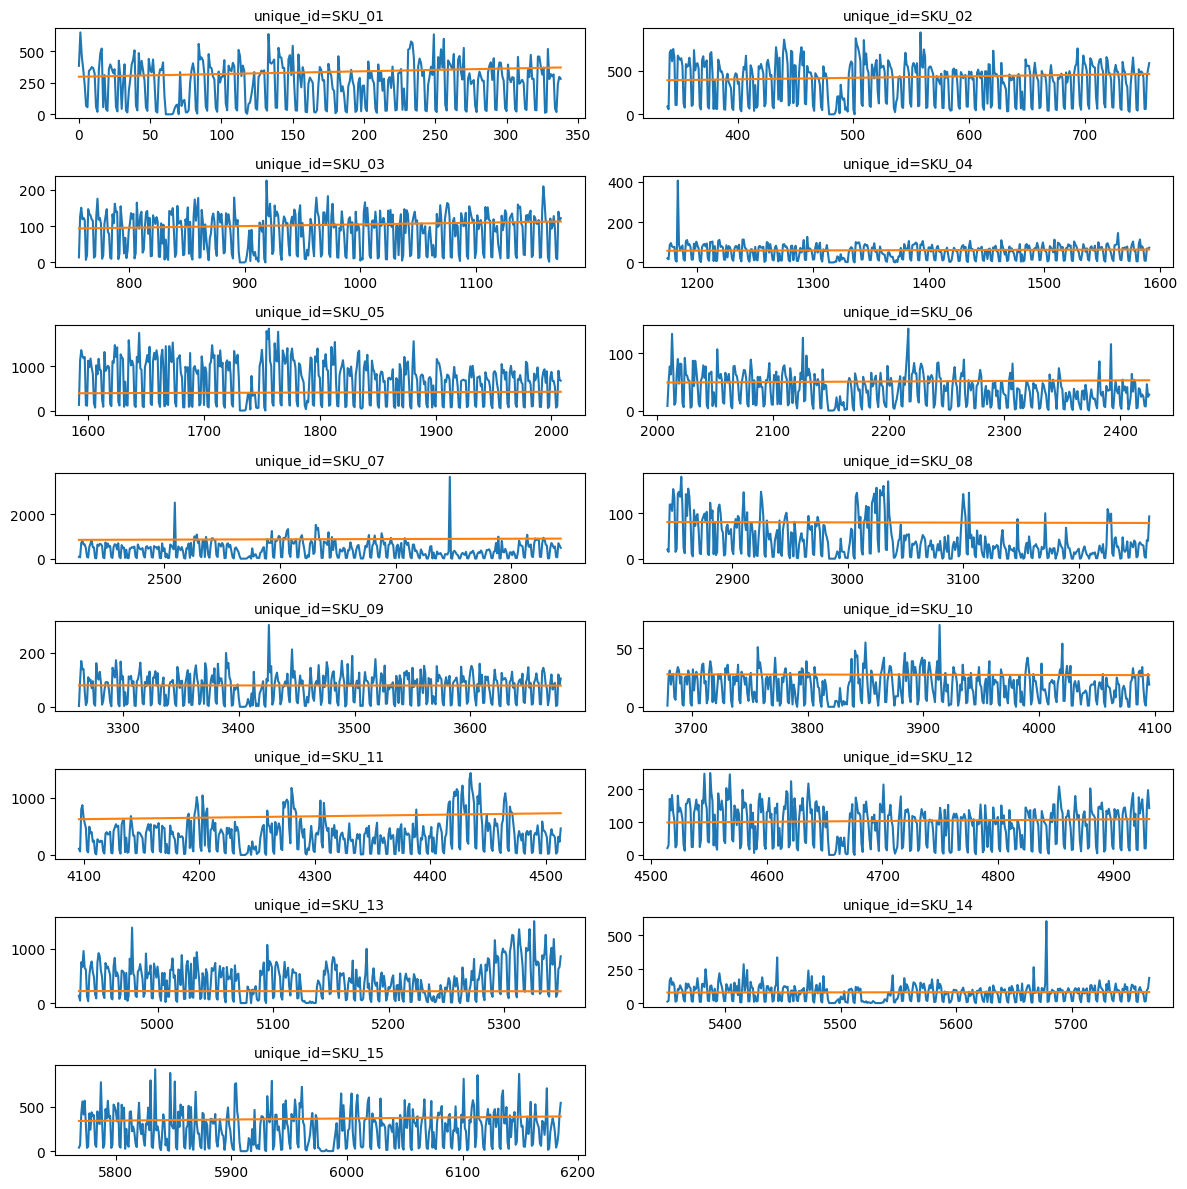

In [7]:
# plot das previsões 
plot_time_series(df=lr_fcst, data_cols=['y', 'y_pred'], figsize=(12,12))

## **Engenharia de Características**
Acrescentaremos algumas features para tentar captar a sazonalidade treinando um modelo de regressão linear múltipla.
Algums preditores são sugeridos em [Forecasting: Principles and Practice (3rd ed) - Useful Predictors](https://otexts.com/fpp3/useful-predictors.html).

In [8]:
# inserindo as features nos dados de treino e teste
features_train_df = (
    train_df
    .groupby("unique_id")
    .apply(lambda x: add_features(df=x, df_type='train'))
    .reset_index(drop=True)
)

features_test_df = (
    test_df
    .groupby("unique_id")
    .apply(lambda x: add_features(df=x, df_type='test'))
    .reset_index(drop=True)
)

In [9]:
features_train_df.head()

,unique_id,ds,y,feriado,day_of_week,week,month,quarter,outlier_min,outlier_max
0,SKU_01,2020-01-28,4.00,0,1,5,1,1,0,0
1,SKU_01,2020-01-29,1.00,0,2,5,1,1,0,0
2,SKU_01,2020-01-30,19.00,0,3,5,1,1,0,0
3,SKU_01,2020-01-31,23.00,0,4,5,1,1,0,0
4,SKU_01,2020-02-01,4.00,0,5,5,2,1,0,0


In [10]:
features_test_df.head()

,unique_id,ds,y,feriado,day_of_week,week,month,quarter,outlier_min,outlier_max
0,SKU_01,2023-10-16,385.00,0,0,42,10,4,0,0
1,SKU_01,2023-10-17,650.00,0,1,42,10,4,0,0
2,SKU_01,2023-10-18,462.00,0,2,42,10,4,0,0
3,SKU_01,2023-10-19,360.00,0,3,42,10,4,0,0
4,SKU_01,2023-10-20,240.00,0,4,42,10,4,0,0


In [11]:
categories = ['day_of_week','week', 'month', 'quarter']

encoder = OneHotEncoder(drop='first')
encoder.fit(features_train_df[categories])


# aplicando nos dados de treino
X_train_encoded = pd.DataFrame(
    data = encoder.transform(features_train_df[categories]).toarray(), 
    columns=encoder.get_feature_names_out()
)

encoded_train_df = pd.concat(
    [features_train_df.drop(columns=categories), X_train_encoded], 
    axis=1
)


# aplicando nos dados de teste
X_test_encoded = pd.DataFrame(
    data = encoder.transform(features_test_df[categories]).toarray(), 
    columns=encoder.get_feature_names_out()
)

encoded_test_df = pd.concat(
    [features_test_df.drop(columns=categories), X_test_encoded], 
    axis=1
)

In [12]:
encoded_train_df.head()

,unique_id,ds,y,feriado,outlier_min,outlier_max,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_2,quarter_3,quarter_4
0,SKU_01,2020-01-28,4.00,0,0,0,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,SKU_01,2020-01-29,1.00,0,0,0,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,SKU_01,2020-01-30,19.00,0,0,0,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,SKU_01,2020-01-31,23.00,0,0,0,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,SKU_01,2020-02-01,4.00,0,0,0,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [13]:
encoded_test_df.head()

,unique_id,ds,y,feriado,outlier_min,outlier_max,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,quarter_2,quarter_3,quarter_4
0,SKU_01,2023-10-16,385.00,0,0,0,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
1,SKU_01,2023-10-17,650.00,0,0,0,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
2,SKU_01,2023-10-18,462.00,0,0,0,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
3,SKU_01,2023-10-19,360.00,0,0,0,0.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00
4,SKU_01,2023-10-20,240.00,0,0,0,0.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00


## **Regressão Linear Múltipla**

In [14]:
def multiple_linear_regression(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aplicação do modelo de regressão linear múltipla.
    """    
    train = df.copy().reset_index(drop=True)
    test = encoded_test_df.query("unique_id == @train.unique_id[0]").reset_index(drop=True)

    train['trend'] = train.index
    test['trend'] = test.index + train.index.max() + 1
    
    m = LinearRegression()
    m.fit(
        X=train.iloc[:,3:], 
        y=train.y
    )
    
    test['y_pred'] = m.predict(X=test.iloc[:,3:])

    return test

In [15]:
mlr_fcst = (
    encoded_train_df
    .groupby("unique_id")
    .apply(multiple_linear_regression)
    .reset_index(drop=True)
)

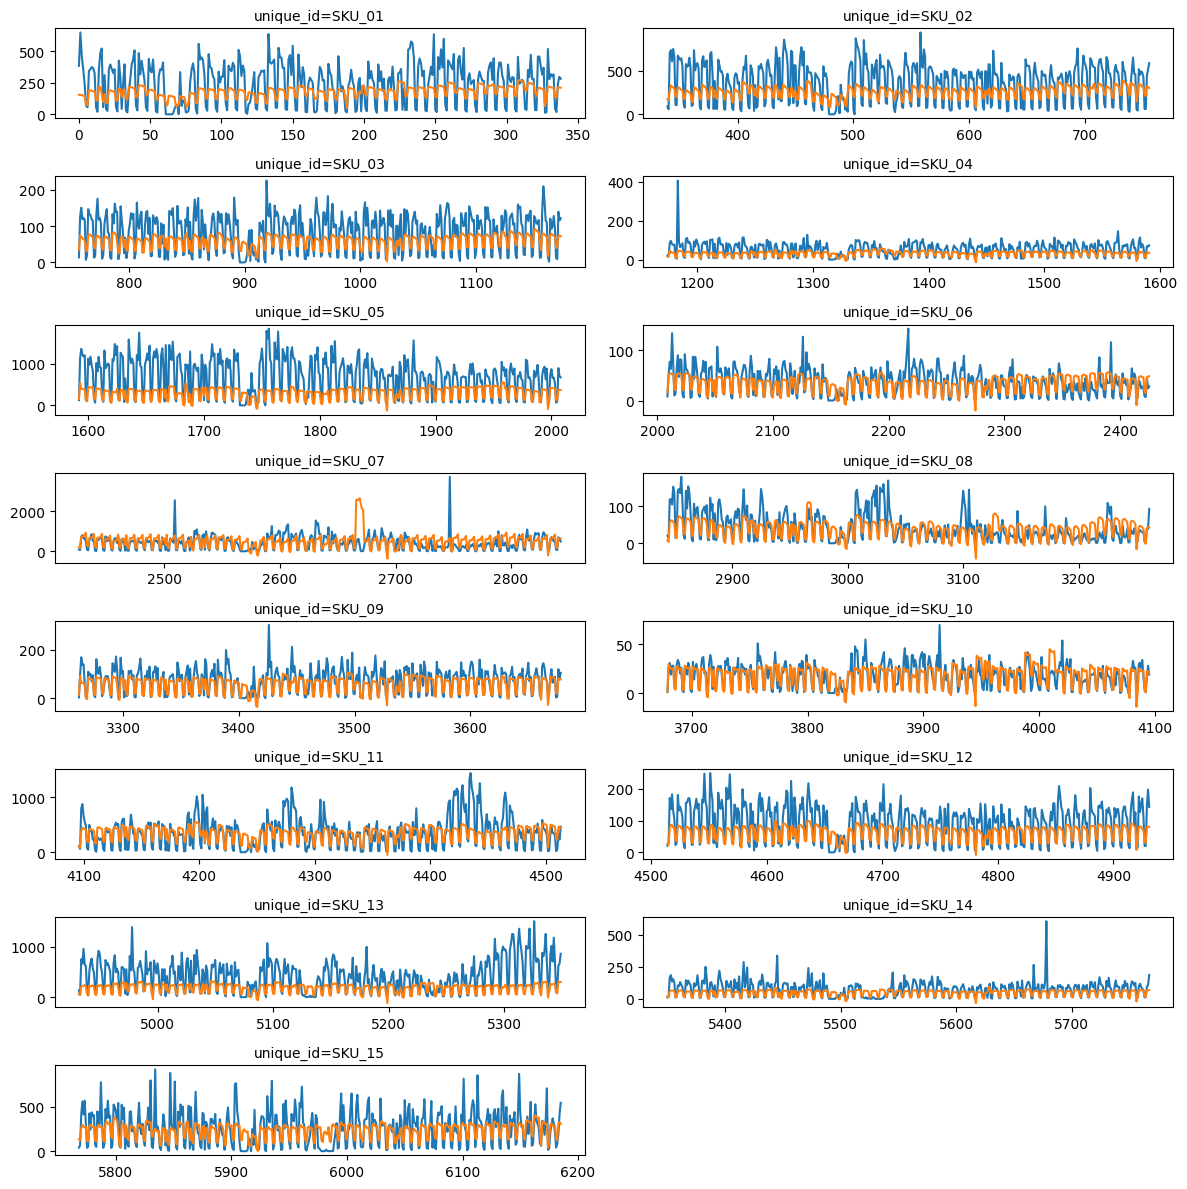

In [16]:
plot_time_series(
    df = mlr_fcst,
    data_cols=['y','y_pred'],
    grid=(8, 2),
    figsize=(12, 12)
)

In [17]:
mlr_eval = Evaluation(mlr_fcst)
mlr_eval.summary()
mlr_eval.save_evaluation(EVAL_PATH, 'Linear Multipla')
mlr_eval.evaluation_df

,mae,mse,rmse,r2
SKU_01,128.47,23500.83,153.30,0.17
SKU_02,182.90,45057.06,212.27,0.14
SKU_03,39.64,2186.16,46.76,0.22
SKU_04,26.53,1372.83,37.05,0.05
SKU_05,412.89,280071.14,529.22,-0.31
SKU_06,14.80,386.44,19.66,0.45
SKU_07,253.71,176691.29,420.35,-0.23
SKU_08,23.80,1040.89,32.26,0.38
SKU_09,24.96,1265.52,35.57,0.52
SKU_10,6.75,83.74,9.15,0.48


## **Comparação com Modelos Benchmark**

In [18]:
models = [
    AutoARIMA(season_length=7),
    AutoETS(season_length=7)
]

sf = StatsForecast(
    models=models,
    freq='D',
    n_jobs=-1
)

def arima_ets_models(df):
    """
    Aplica os modelos SARIMA e ETS.
    """
    train = df.copy().reset_index(drop=True)
    test = test_df.query("unique_id == @train.unique_id[0]").reset_index(drop=True)

    sf.fit(df=train)
    predict = sf.predict(h=len(test)).reset_index(drop=True)
    
    test['ARIMA'] = predict['AutoARIMA']
    test['ETS'] = predict['AutoETS']
    return test

In [19]:
benchmark_fcst = train_df.groupby("unique_id").progress_apply(arima_ets_models).reset_index(drop=True)

100%|██████████| 15/15 [05:35<00:00, 22.35s/it]


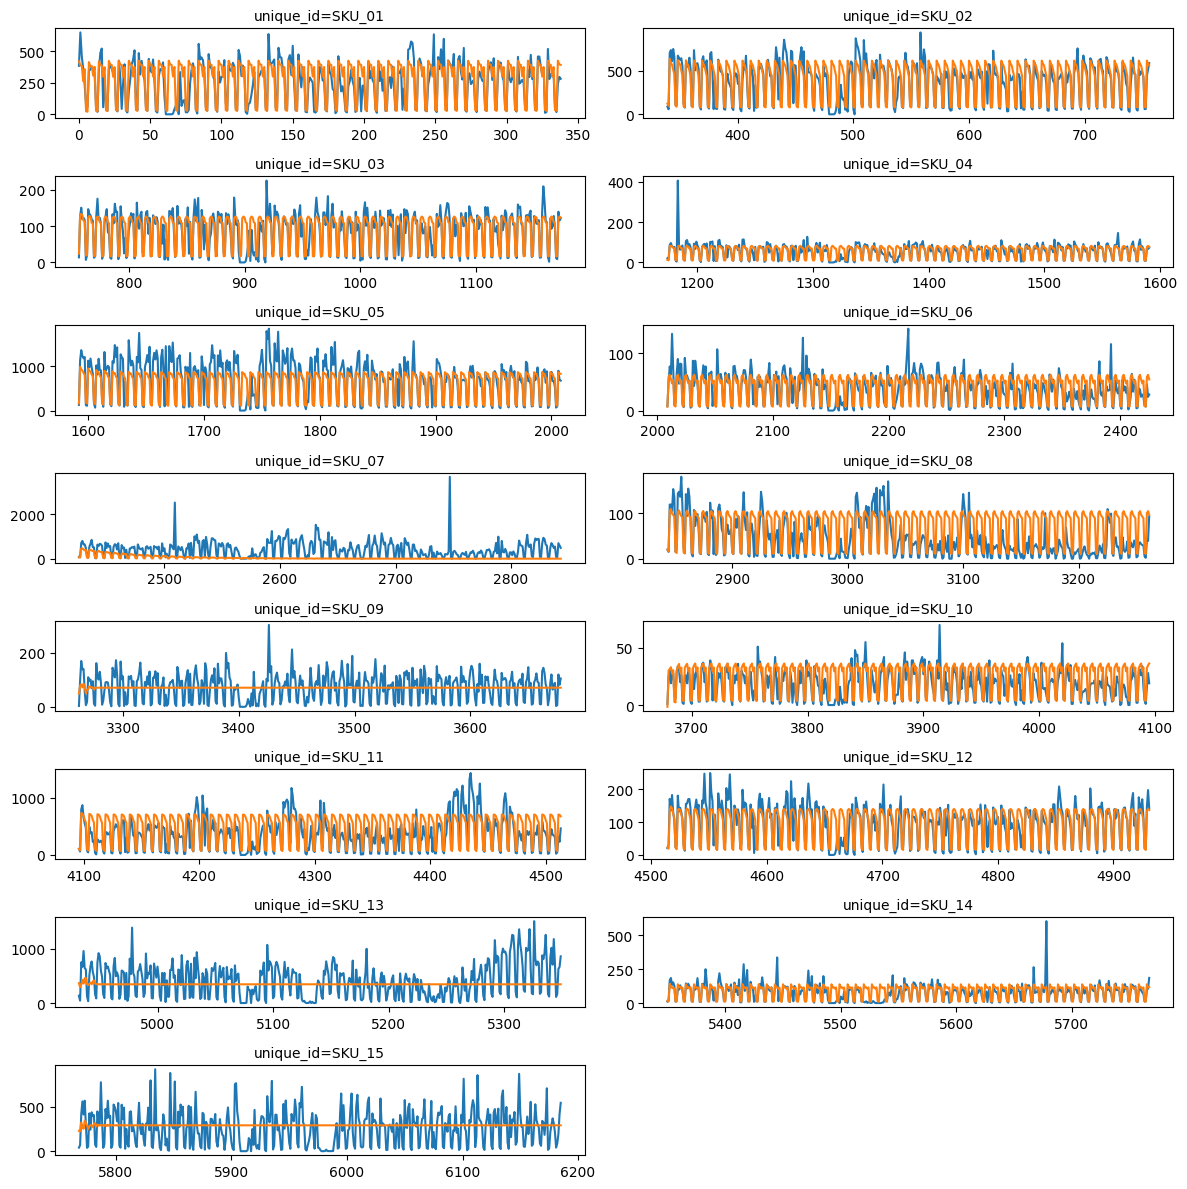

In [20]:
# plot das previsões ARIMA
plot_time_series(
    df=benchmark_fcst,
    data_cols=['y','ARIMA'],
    id_col='unique_id',
    grid=(8, 2),
    figsize=(12, 12)
)

In [21]:
arima_eval = Evaluation(df=benchmark_fcst, y_pred_col='ARIMA')
arima_eval.summary()
arima_eval.save_evaluation(EVAL_PATH, 'ARIMA')
arima_eval.evaluation_df

,mae,mse,rmse,r2
SKU_01,74.41,12655.79,112.50,0.55
SKU_02,90.91,19036.19,137.97,0.64
SKU_03,20.43,984.75,31.38,0.65
SKU_04,14.58,697.11,26.40,0.52
SKU_05,197.36,85044.03,291.62,0.60
SKU_06,14.07,395.89,19.90,0.44
SKU_07,376.70,278923.62,528.13,-0.95
SKU_08,38.11,2346.22,48.44,-0.40
SKU_09,43.78,2629.41,51.28,0.01
SKU_10,8.85,143.53,11.98,0.10


In [22]:
ets_eval = Evaluation(df=benchmark_fcst, y_pred_col='ETS')
ets_eval.summary()
ets_eval.save_evaluation(EVAL_PATH, 'ETS')
ets_eval.evaluation_df

,mae,mse,rmse,r2
SKU_01,73.90,11308.87,106.34,0.60
SKU_02,102.96,22224.44,149.08,0.58
SKU_03,22.01,1082.04,32.89,0.62
SKU_04,15.42,731.30,27.04,0.50
SKU_05,211.53,82603.71,287.41,0.61
SKU_06,14.23,402.58,20.06,0.43
SKU_07,279.56,142985.88,378.13,0.00
SKU_08,45.23,3019.06,54.95,-0.80
SKU_09,22.39,1089.22,33.00,0.59
SKU_10,8.81,114.48,10.70,0.28


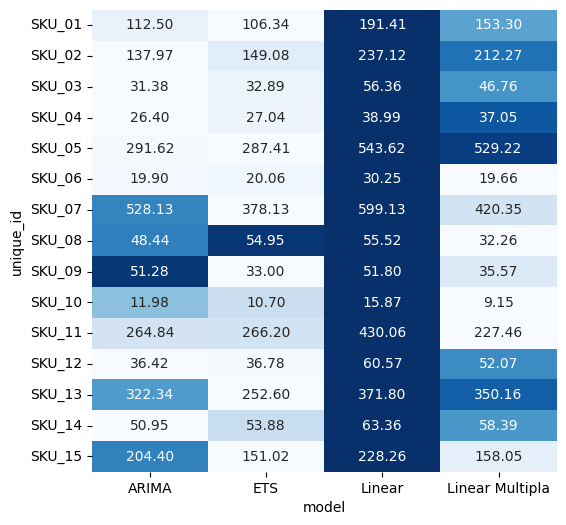

In [23]:
# comparação dos modelos
metrics = pd.read_csv(EVAL_PATH)[['unique_id', 'rmse', 'model']].pivot_table('rmse','unique_id','model')

plot_metrics(metrics)